In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
import math
import pandas_datareader as web
import yfinance as yf #helps to download data from yahoo finance

In [12]:

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [15]:
data = yf.download('^NSEBANK', start = datetime.datetime(2000, 1, 2), end = date.today())
data = data[['Adj Close']] #Took only one column
data.columns = ['Price']
data.head()

[*********************100%%**********************]  1 of 1 completed


,Price
Date,
2007-09-17,6897.020020
2007-09-18,7059.567871
2007-09-19,7401.764160
2007-09-20,7390.063965
2007-09-21,7464.413086


In [16]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 3850 number of days in the dataset.


In [20]:
data.index

DatetimeIndex(['2007-09-17', '2007-09-18', '2007-09-19', '2007-09-20',
               '2007-09-21', '2007-09-24', '2007-09-25', '2007-09-26',
               '2007-09-27', '2007-09-28',
               ...
               '2024-07-02', '2024-07-03', '2024-07-04', '2024-07-05',
               '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-15'],
              dtype='datetime64[ns]', name='Date', length=3850, freq=None)

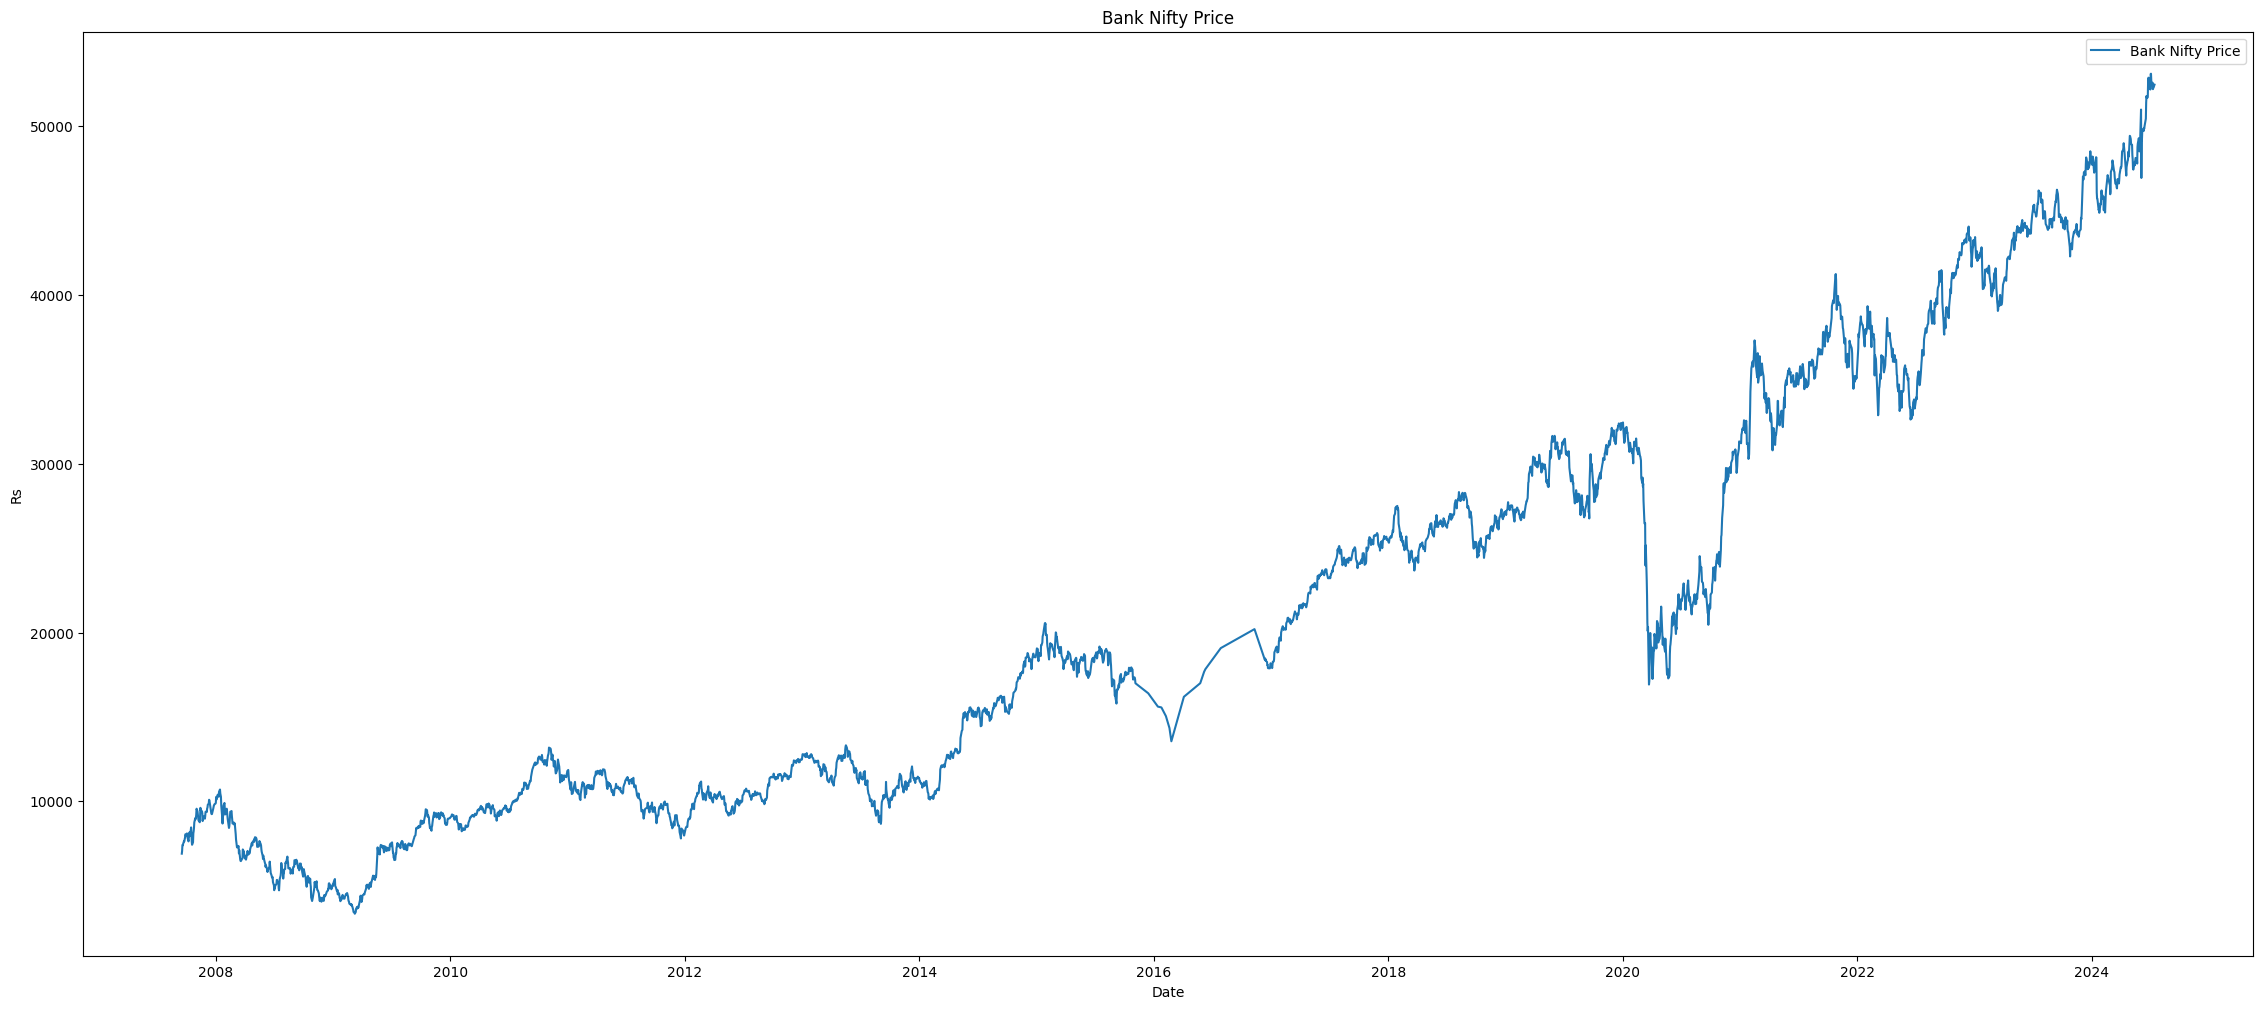

In [21]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(data.index, data['Price'], label='Bank Nifty Price')
plt.xlabel('Date')
plt.ylabel('Rs')
plt.title('Bank Nifty Price')
plt.legend()
plt.show()

In [49]:
def get_technical_indicators(data):
  #moving Average
  data['ma7'] = data['Price'].rolling(window=7).mean()
  data['ma21'] = data['Price'].rolling(window=21).mean()
  #MACD Line
  data['ema26'] = data['Price'].ewm(span=26).mean()
  data['ema12'] = data['Price'].ewm(span=12).mean()
  data['MACD'] = data['ema12'] - data['ema26']

  #Exponential Moving Line
  data['ema'] = data['Price'].ewm(com=0.5).mean()
  period = 10
  #Bollinger Band
  data['20sd'] = data['Price'].rolling(window = 21).std()
  data['upper_band'] = data['ma21'] + (data['20sd']*2)
  data['lower_band'] = data['ma21'] - (data['20sd']*2)
  #momentum as an indicator
  data['momentum'] = data['Price'].diff(period)

# Calculate log momentum, taking care to avoid taking log of non-positive values
  data['log_momentum'] = data['momentum'].apply(lambda x: np.log(x) if x > 0 else np.nan)

  return data



In [50]:
df = get_technical_indicators(data)

Data Preprocessing

In [48]:
print(df['log_momentum'])

Date
2007-10-16    5.111376
2007-10-22    4.971192
2007-10-23    6.278697
2007-10-24    4.848499
2007-10-25    5.298308
                ...   
2024-07-04    2.670640
2024-07-09    4.962845
2024-07-11    4.398732
2024-07-12    2.110213
2024-07-15    5.176150
Name: log_momentum, Length: 2011, dtype: float64


In [51]:
#Dropping the rows and column having Null values

df = df.dropna()
df.head()

,Price,ma7,ma21,ema26,ema12,MACD,ema,20sd,upper_band,lower_band,momentum,log_momentum
Date,,,,,,,,,,,,
2007-10-16,8452.101562,8054.791922,7784.471354,7923.731019,8042.612357,118.881339,8363.607803,386.856369,8558.184092,7010.758617,464.694336,6.141380
2007-10-17,8099.805664,8122.434012,7841.746861,7939.713390,8051.640133,111.926742,8187.739710,334.374992,8510.496844,7172.996878,2.000000,0.693147
2007-10-23,8101.005859,7934.200474,7907.722284,7863.638751,7883.627861,19.989110,7921.284909,261.172287,8430.066858,7385.377710,205.247559,5.324217
2007-10-24,8228.554688,7925.964983,7935.233887,7894.537703,7937.283383,42.745680,8126.131428,263.178139,8461.590165,7408.877609,197.998047,5.288257
2007-10-25,8428.552734,7922.600865,7973.304920,7939.280699,8013.572937,74.292238,8327.745632,274.266189,8521.837299,7424.772542,269.847656,5.597858


In [52]:
df.shape  #20 rows with null values removed


(2176, 12)

In [53]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.figure(figsize=(30,20))
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot

    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
#     plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

<Figure size 1600x1000 with 0 Axes>

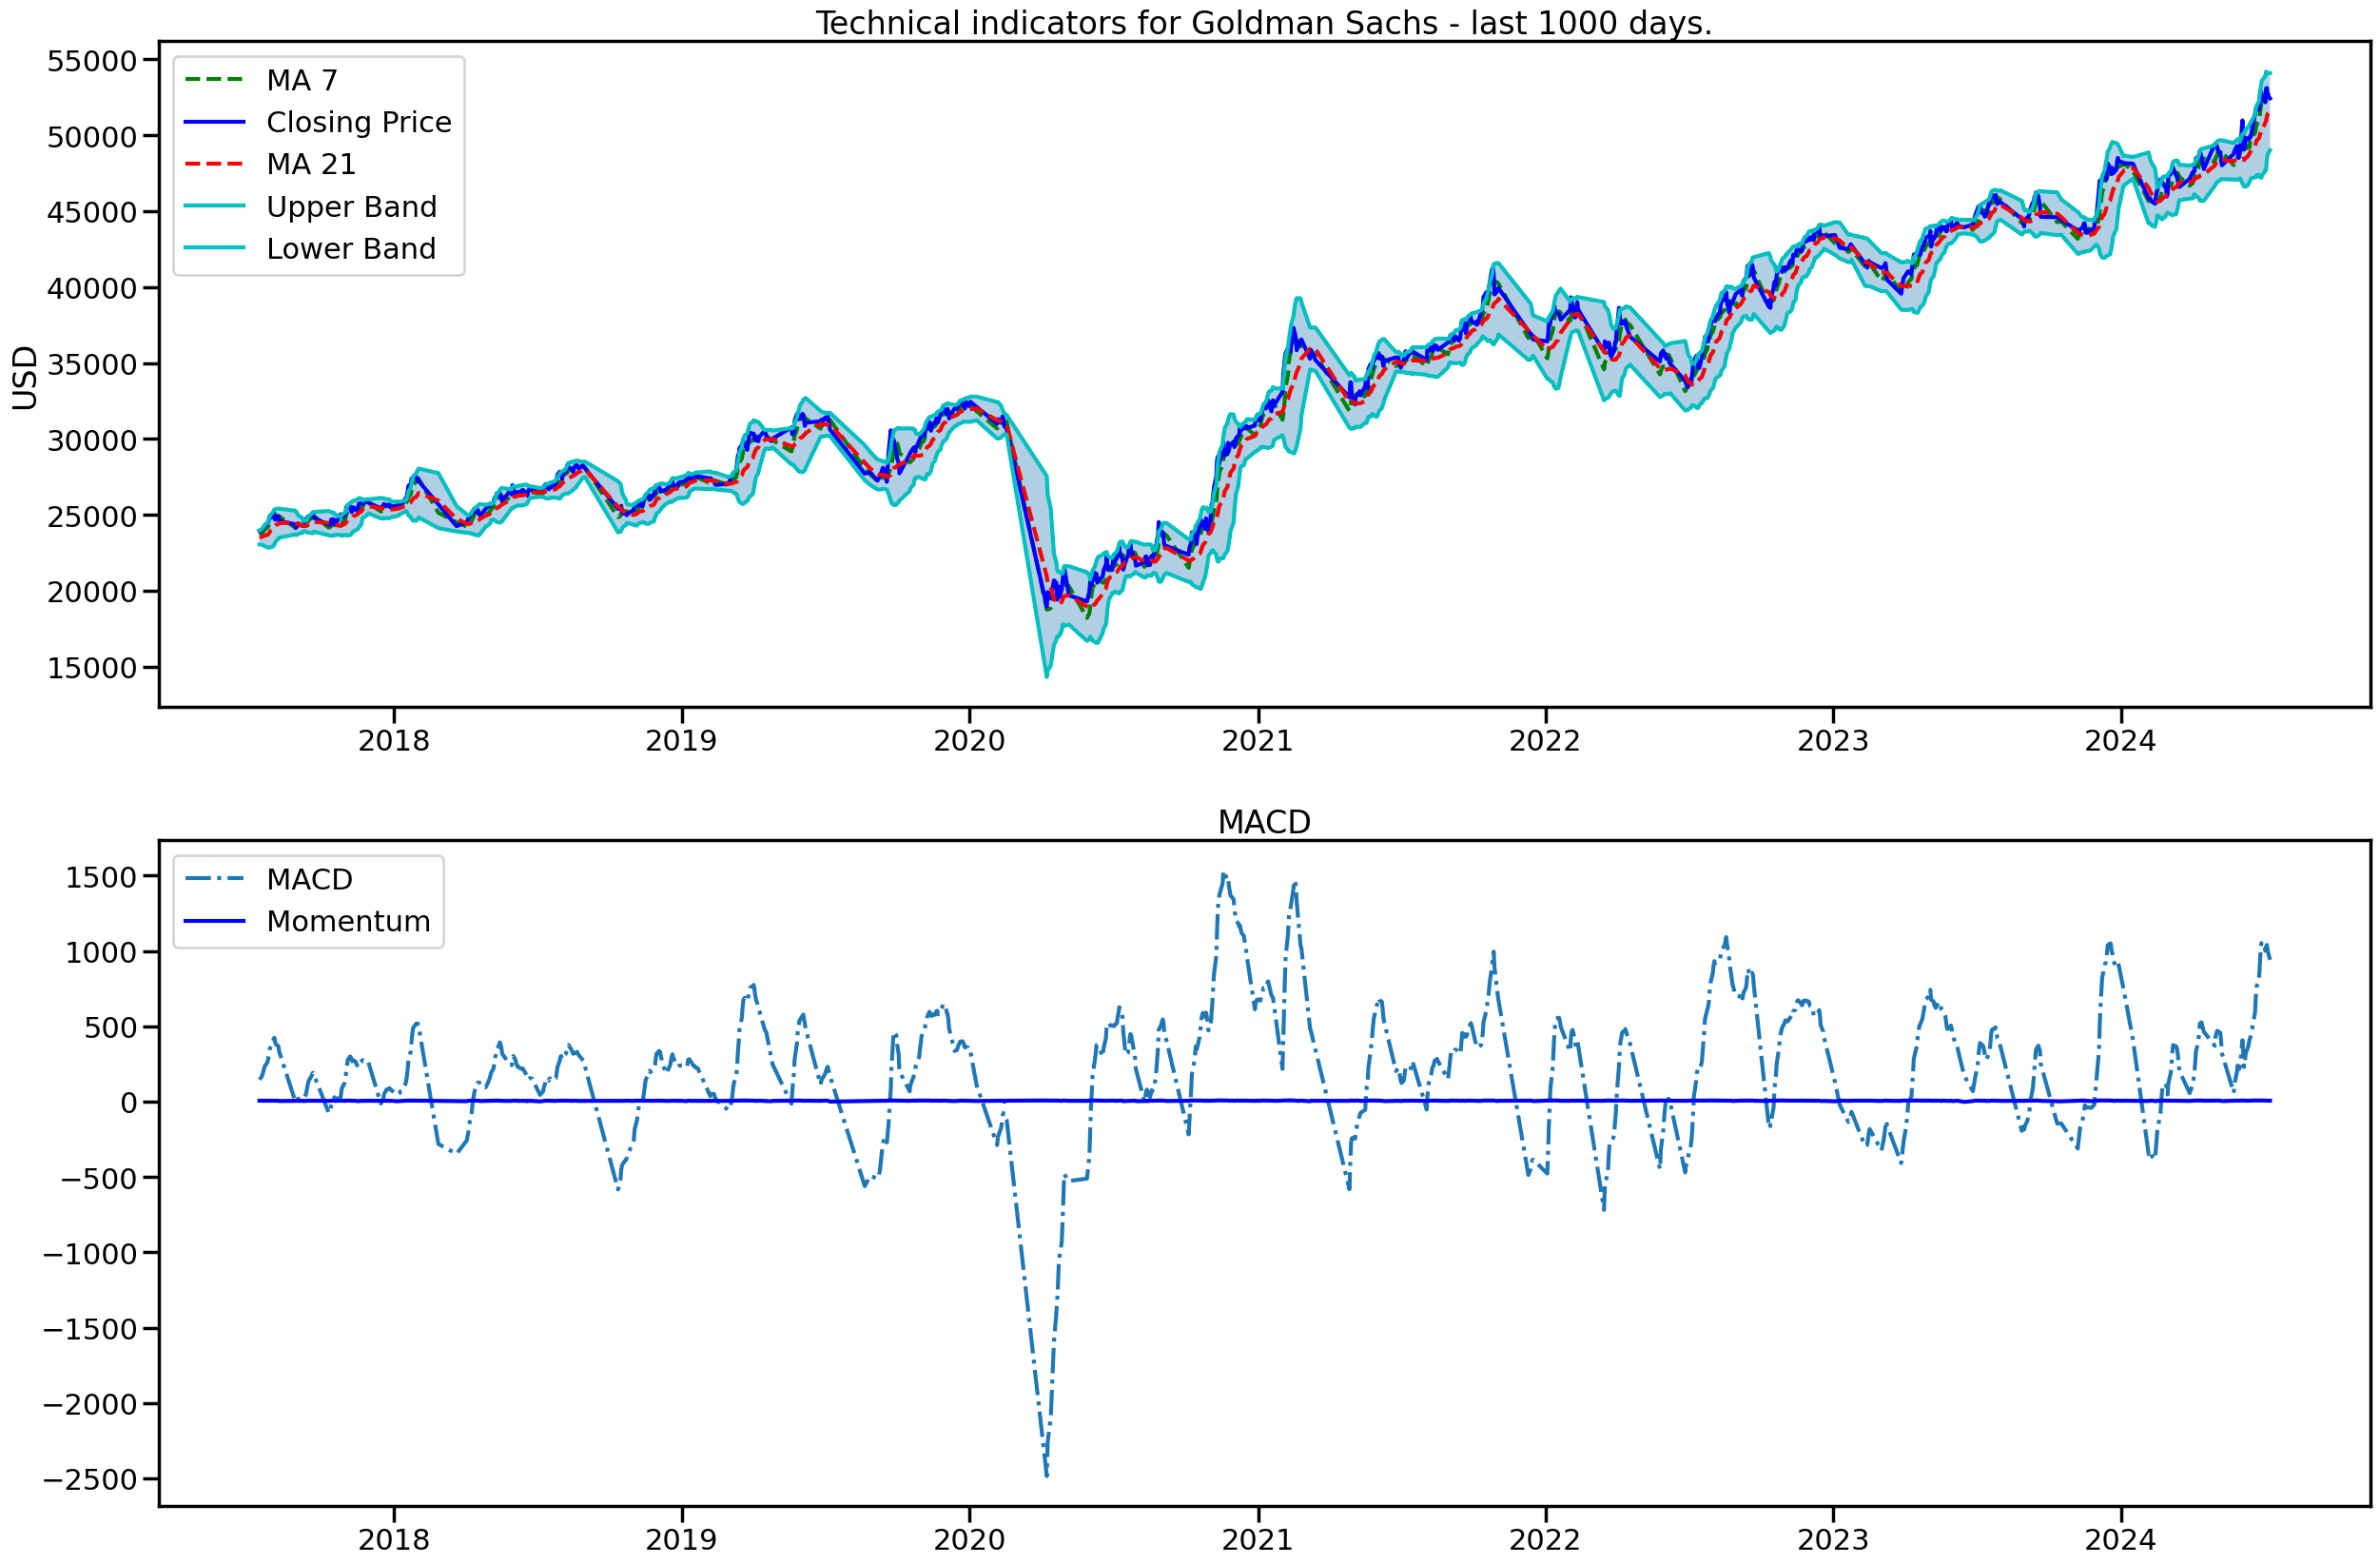

In [54]:
plot_technical_indicators(df,1000)

Text(0.5, 1.0, 'Params')

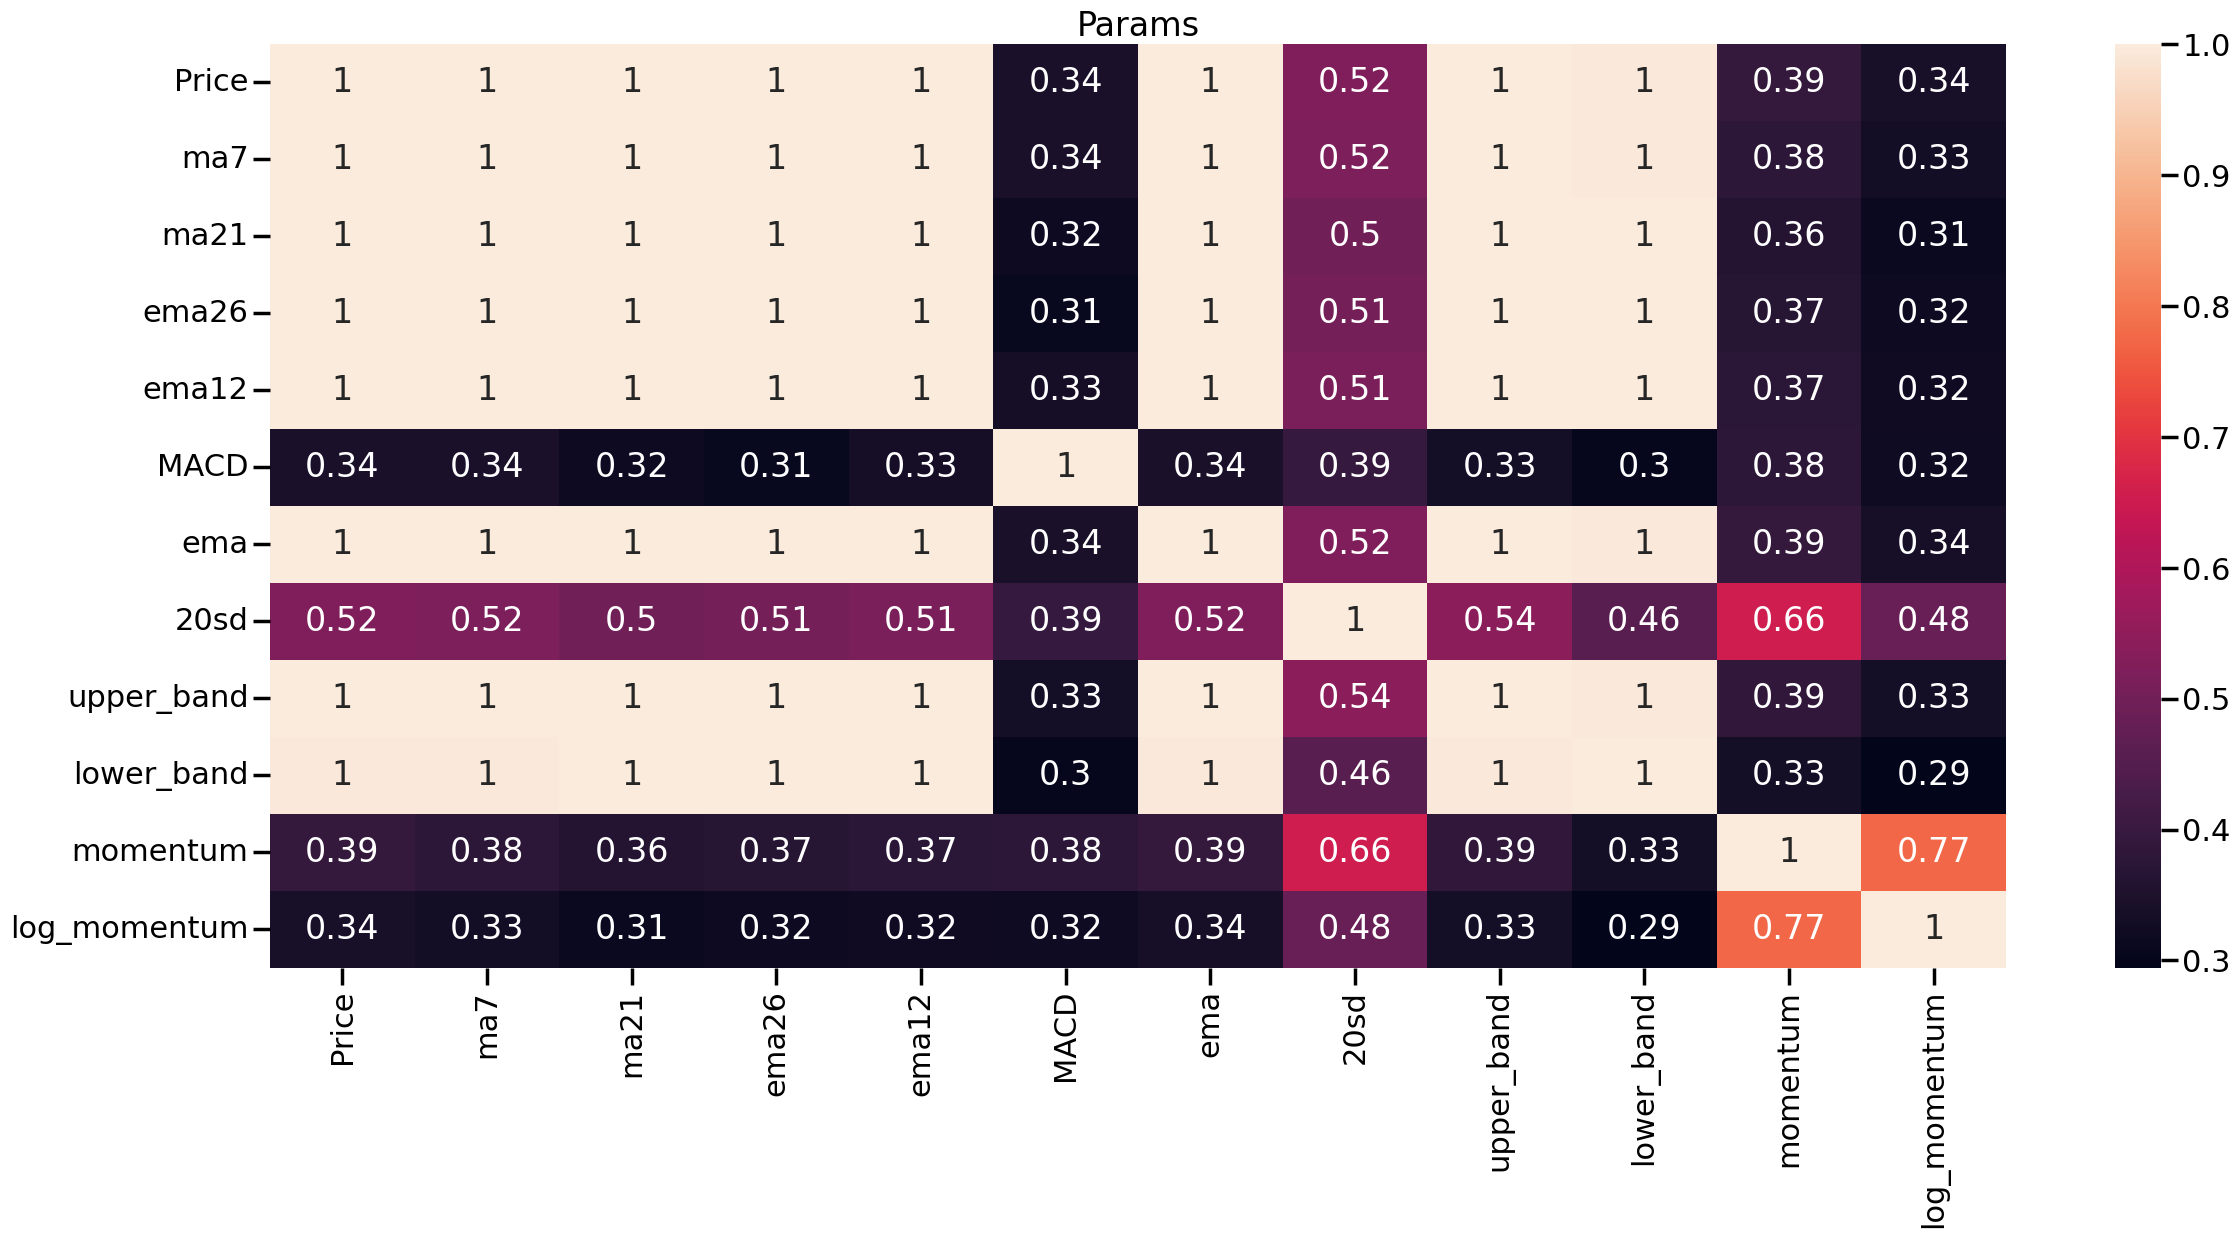

In [55]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(df.corr(), annot = True).set_title('Params')

This heatmap allows you to quickly identify relationships between different financial indicators. Highly correlated variables can be useful for certain types of analyses and strategies, while weakly or negatively correlated variables might offer diversification benefits in a portfolio. The visualization helps in understanding the structure and relationships in your data, guiding further analysis or decision-making.

In [56]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0],df.shape[1]))

Total dataset has 2176 samples, and 12 features.


In [57]:
df.columns

Index(['Price', 'ma7', 'ma21', 'ema26', 'ema12', 'MACD', 'ema', '20sd',
       'upper_band', 'lower_band', 'momentum', 'log_momentum'],
      dtype='object')

In [58]:
df

,Price,ma7,ma21,ema26,ema12,MACD,ema,20sd,upper_band,lower_band,momentum,log_momentum
Date,,,,,,,,,,,,
2007-10-16,8452.101562,8054.791922,7784.471354,7923.731019,8042.612357,118.881339,8363.607803,386.856369,8558.184092,7010.758617,464.694336,6.141380
2007-10-17,8099.805664,8122.434012,7841.746861,7939.713390,8051.640133,111.926742,8187.739710,334.374992,8510.496844,7172.996878,2.000000,0.693147
2007-10-23,8101.005859,7934.200474,7907.722284,7863.638751,7883.627861,19.989110,7921.284909,261.172287,8430.066858,7385.377710,205.247559,5.324217
2007-10-24,8228.554688,7925.964983,7935.233887,7894.537703,7937.283383,42.745680,8126.131428,263.178139,8461.590165,7408.877609,197.998047,5.288257
2007-10-25,8428.552734,7922.600865,7973.304920,7939.280699,8013.572937,74.292238,8327.745632,274.266189,8521.837299,7424.772542,269.847656,5.597858
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-02,52168.101562,52439.550223,50840.438058,50812.628082,51813.532253,1000.904171,52293.555529,1547.693022,53935.824103,47745.052013,1727.203125,7.454259
2024-07-03,53089.250000,52637.450335,50940.880952,50981.266743,52009.796522,1028.529779,52824.018510,1623.774943,54188.430839,47693.331065,1691.199219,7.433193
2024-07-04,53103.699219,52708.550223,51234.933222,51138.483963,52178.089245,1039.605281,53010.472316,1405.284612,54045.502446,48424.363998,1320.449219,7.185727


In [59]:
data_training = df[df.index < '2019-01-31'].copy()
data_training

,Price,ma7,ma21,ema26,ema12,MACD,ema,20sd,upper_band,lower_band,momentum,log_momentum
Date,,,,,,,,,,,,
2007-10-16,8452.101562,8054.791922,7784.471354,7923.731019,8042.612357,118.881339,8363.607803,386.856369,8558.184092,7010.758617,464.694336,6.141380
2007-10-17,8099.805664,8122.434012,7841.746861,7939.713390,8051.640133,111.926742,8187.739710,334.374992,8510.496844,7172.996878,2.000000,0.693147
2007-10-23,8101.005859,7934.200474,7907.722284,7863.638751,7883.627861,19.989110,7921.284909,261.172287,8430.066858,7385.377710,205.247559,5.324217
2007-10-24,8228.554688,7925.964983,7935.233887,7894.537703,7937.283383,42.745680,8126.131428,263.178139,8461.590165,7408.877609,197.998047,5.288257
2007-10-25,8428.552734,7922.600865,7973.304920,7939.280699,8013.572937,74.292238,8327.745632,274.266189,8521.837299,7424.772542,269.847656,5.597858
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-15,27400.431641,27451.952846,27181.619885,27061.175522,27303.959372,242.783850,27376.357112,258.297678,27698.215241,26665.024528,240.548828,5.482923
2019-01-16,27483.378906,27477.544922,27212.938523,27092.449847,27331.562378,239.112531,27447.704975,252.796999,27718.532521,26707.344525,308.996094,5.733329
2019-01-17,27528.429688,27480.294922,27237.364397,27124.744650,27361.849656,237.105006,27501.521450,257.501910,27752.368217,26722.360578,568.892578,6.343692


In [60]:
data_testing = df[df.index >= '2019-01-31'].copy()
data_testing

,Price,ma7,ma21,ema26,ema12,MACD,ema,20sd,upper_band,lower_band,momentum,log_momentum
Date,,,,,,,,,,,,
2019-02-06,27402.031250,27091.249163,27274.125837,27146.530986,27183.350232,36.819246,27345.720842,294.059781,27862.245398,26686.006276,151.597656,5.021230
2019-02-07,27386.832031,27207.497768,27258.256975,27164.331064,27214.655124,50.324060,27373.128301,277.305256,27812.867487,26703.646464,120.748047,4.793706
2019-02-08,27294.083984,27274.482980,27247.107143,27173.942391,27226.874949,52.932558,27320.432090,270.532003,27788.171149,26706.043137,179.097656,5.187931
2019-02-11,27227.484375,27264.818917,27236.340588,27177.908464,27226.968707,49.060243,27258.466947,266.370998,27769.082584,26703.598592,574.744141,6.353925
2019-02-12,27010.435547,27254.076172,27225.031157,27165.503063,27193.655913,28.152850,27093.112680,270.858163,27766.747484,26683.314830,437.343750,6.080719
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-02,52168.101562,52439.550223,50840.438058,50812.628082,51813.532253,1000.904171,52293.555529,1547.693022,53935.824103,47745.052013,1727.203125,7.454259
2024-07-03,53089.250000,52637.450335,50940.880952,50981.266743,52009.796522,1028.529779,52824.018510,1623.774943,54188.430839,47693.331065,1691.199219,7.433193
2024-07-04,53103.699219,52708.550223,51234.933222,51138.483963,52178.089245,1039.605281,53010.472316,1405.284612,54045.502446,48424.363998,1320.449219,7.185727


In [61]:
#Scaling the values

scalar = MinMaxScaler()

data_training_scaled = scalar.fit_transform(data_training)
print(data_training_scaled.shape)
data_training_scaled

(1407, 12)


array([[1.93293896e-01, 1.82402736e-01, 1.67125158e-01, ...,
        1.57885385e-01, 9.56617788e-02, 7.14916535e-01],
       [1.78989214e-01, 1.85152871e-01, 1.69484833e-01, ...,
        1.64555458e-01, 1.44546223e-04, 5.24022039e-02],
       [1.79037947e-01, 1.77499830e-01, 1.72202932e-01, ...,
        1.73287035e-01, 4.21023633e-02, 6.15548129e-01],
       ...,
       [9.67872348e-01, 9.72188506e-01, 9.68558428e-01, ...,
        9.68285085e-01, 1.17172152e-01, 7.39517990e-01],
       [9.64946865e-01, 9.70656909e-01, 9.69111663e-01, ...,
        9.68518531e-01, 5.37556717e-02, 6.45093876e-01],
       [9.68069262e-01, 9.70686233e-01, 9.69573079e-01, ...,
        9.68397567e-01, 4.70150197e-02, 6.28887993e-01]])

In [62]:
X_train = []
y_train = []


In [66]:
for i in range(60, data_training.shape[0]):
    X_train.append(data_training_scaled[i-60: i])
    y_train.append(data_training_scaled[i, 0])

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [64]:
data_training_scaled

array([[1.93293896e-01, 1.82402736e-01, 1.67125158e-01, ...,
        1.57885385e-01, 9.56617788e-02, 7.14916535e-01],
       [1.78989214e-01, 1.85152871e-01, 1.69484833e-01, ...,
        1.64555458e-01, 1.44546223e-04, 5.24022039e-02],
       [1.79037947e-01, 1.77499830e-01, 1.72202932e-01, ...,
        1.73287035e-01, 4.21023633e-02, 6.15548129e-01],
       ...,
       [9.67872348e-01, 9.72188506e-01, 9.68558428e-01, ...,
        9.68285085e-01, 1.17172152e-01, 7.39517990e-01],
       [9.64946865e-01, 9.70656909e-01, 9.69111663e-01, ...,
        9.68518531e-01, 5.37556717e-02, 6.45093876e-01],
       [9.68069262e-01, 9.70686233e-01, 9.69573079e-01, ...,
        9.68397567e-01, 4.70150197e-02, 6.28887993e-01]])

In [65]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((1347, 60, 12), (1347,))

In [67]:
l = [1,2,3,4]

In [69]:
regressor = Sequential()

regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 12)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

In [70]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            12600     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [71]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [72]:
regressor.fit(X_train, y_train, epochs=50, batch_size = 64)

Epoch 1/50
22/22 [==============================] - 9s 159ms/step - loss: 0.0881
Epoch 2/50
22/22 [==============================] - 3s 155ms/step - loss: 0.0170
Epoch 3/50
22/22 [==============================] - 4s 203ms/step - loss: 0.0105
Epoch 4/50
22/22 [==============================] - 3s 152ms/step - loss: 0.0090
Epoch 5/50
22/22 [==============================] - 4s 169ms/step - loss: 0.0083
Epoch 6/50
22/22 [==============================] - 5s 225ms/step - loss: 0.0073
Epoch 7/50
22/22 [==============================] - 4s 169ms/step - loss: 0.0077
Epoch 8/50
22/22 [==============================] - 4s 185ms/step - loss: 0.0068
Epoch 9/50
22/22 [==============================] - 5s 222ms/step - loss: 0.0071
Epoch 10/50
22/22 [==============================] - 4s 171ms/step - loss: 0.0072
Epoch 11/50
22/22 [==============================] - 4s 171ms/step - loss: 0.0064
Epoch 12/50
22/22 [==============================] - 5s 213ms/step - loss: 0.0062
Epoch 13/50
22/22 [======

In [75]:
past_60 = data_training.tail(60)

dt = pd.concat([past_60, data_testing], ignore_index=True)
dt

,Price,ma7,ma21,ema26,ema12,MACD,ema,20sd,upper_band,lower_band,momentum,log_momentum
0,28027.574219,28046.995815,27805.088821,27678.190921,27987.579521,309.388599,28097.587579,374.899272,28554.887366,27055.290276,151.998047,5.023868
1,28269.322266,28150.694475,27945.870443,27772.067253,28050.015999,277.948747,28229.532034,261.975685,28469.821812,27421.919073,145.398438,4.979478
2,28223.771484,28164.344029,27973.950986,27805.526825,28076.747612,271.220787,28225.691668,258.464900,28490.880786,27457.021186,429.693359,6.063072
3,28102.923828,28139.915737,27986.362816,27827.556233,28080.774723,253.218489,28143.846441,258.083562,28502.529940,27470.195692,81.550781,4.401226
4,28061.423828,28111.894531,28000.534040,27844.879759,28077.797662,232.917903,28088.898033,253.380906,28507.295852,27493.772228,235.197266,5.460425
...,...,...,...,...,...,...,...,...,...,...,...,...
824,52168.101562,52439.550223,50840.438058,50812.628082,51813.532253,1000.904171,52293.555529,1547.693022,53935.824103,47745.052013,1727.203125,7.454259
825,53089.250000,52637.450335,50940.880952,50981.266743,52009.796522,1028.529779,52824.018510,1623.774943,54188.430839,47693.331065,1691.199219,7.433193
826,53103.699219,52708.550223,51234.933222,51138.483963,52178.089245,1039.605281,53010.472316,1405.284612,54045.502446,48424.363998,1320.449219,7.185727
827,52660.351562,52678.529018,51406.635603,51251.214897,52252.283447,1001.068551,52777.058480,1344.532489,54095.700580,48717.570626,998.902344,6.906657


In [76]:
inputs = scalar.fit_transform(dt)
print(inputs.shape)
inputs

(829, 12)


array([[0.26586704, 0.28514032, 0.27373002, ..., 0.36710471, 0.02736787,
        0.63431025],
       [0.2729445 , 0.28814621, 0.27803495, ..., 0.37767074, 0.02617726,
        0.62979669],
       [0.27161095, 0.28854187, 0.27889362, ..., 0.37868236, 0.0774659 ,
        0.73997631],
       ...,
       [1.        , 1.        , 0.99018617, ..., 0.98294892, 0.238164  ,
        0.85412768],
       [0.98702048, 0.99912978, 0.99543662, ..., 0.99139896, 0.18015487,
        0.82575188],
       [0.98015373, 0.99753344, 1.        , ..., 1.        , 0.13017312,
        0.79272247]])

In [77]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((769, 60, 12), (769,))

In [78]:
y_pred = regressor.predict(X_test)

25/25 [==============================] - 2s 45ms/step


In [79]:
y_pred

array([[0.24673942],
       [0.24778964],
       [0.24859759],
       [0.24917066],
       [0.24960254],
       [0.24995239],
       [0.25020212],
       [0.2503318 ],
       [0.25043997],
       [0.25062203],
       [0.25092274],
       [0.25134322],
       [0.2519306 ],
       [0.25275576],
       [0.25397044],
       [0.2557093 ],
       [0.25817207],
       [0.2614873 ],
       [0.2656443 ],
       [0.27051443],
       [0.2758481 ],
       [0.28131384],
       [0.28673697],
       [0.2919799 ],
       [0.296964  ],
       [0.30163342],
       [0.30589646],
       [0.30961382],
       [0.3126238 ],
       [0.31485105],
       [0.31631806],
       [0.31721836],
       [0.31761563],
       [0.3175807 ],
       [0.31713784],
       [0.31641692],
       [0.31561565],
       [0.31489187],
       [0.31445694],
       [0.3144261 ],
       [0.31494308],
       [0.31622487],
       [0.3183836 ],
       [0.32140562],
       [0.32520497],
       [0.3295626 ],
       [0.33412427],
       [0.338

In [81]:
scale = 1/scalar.scale_[0]  #Transforming the transformed data back to its original

In [82]:
y_pred = y_pred*scale
y_test = y_test*scale

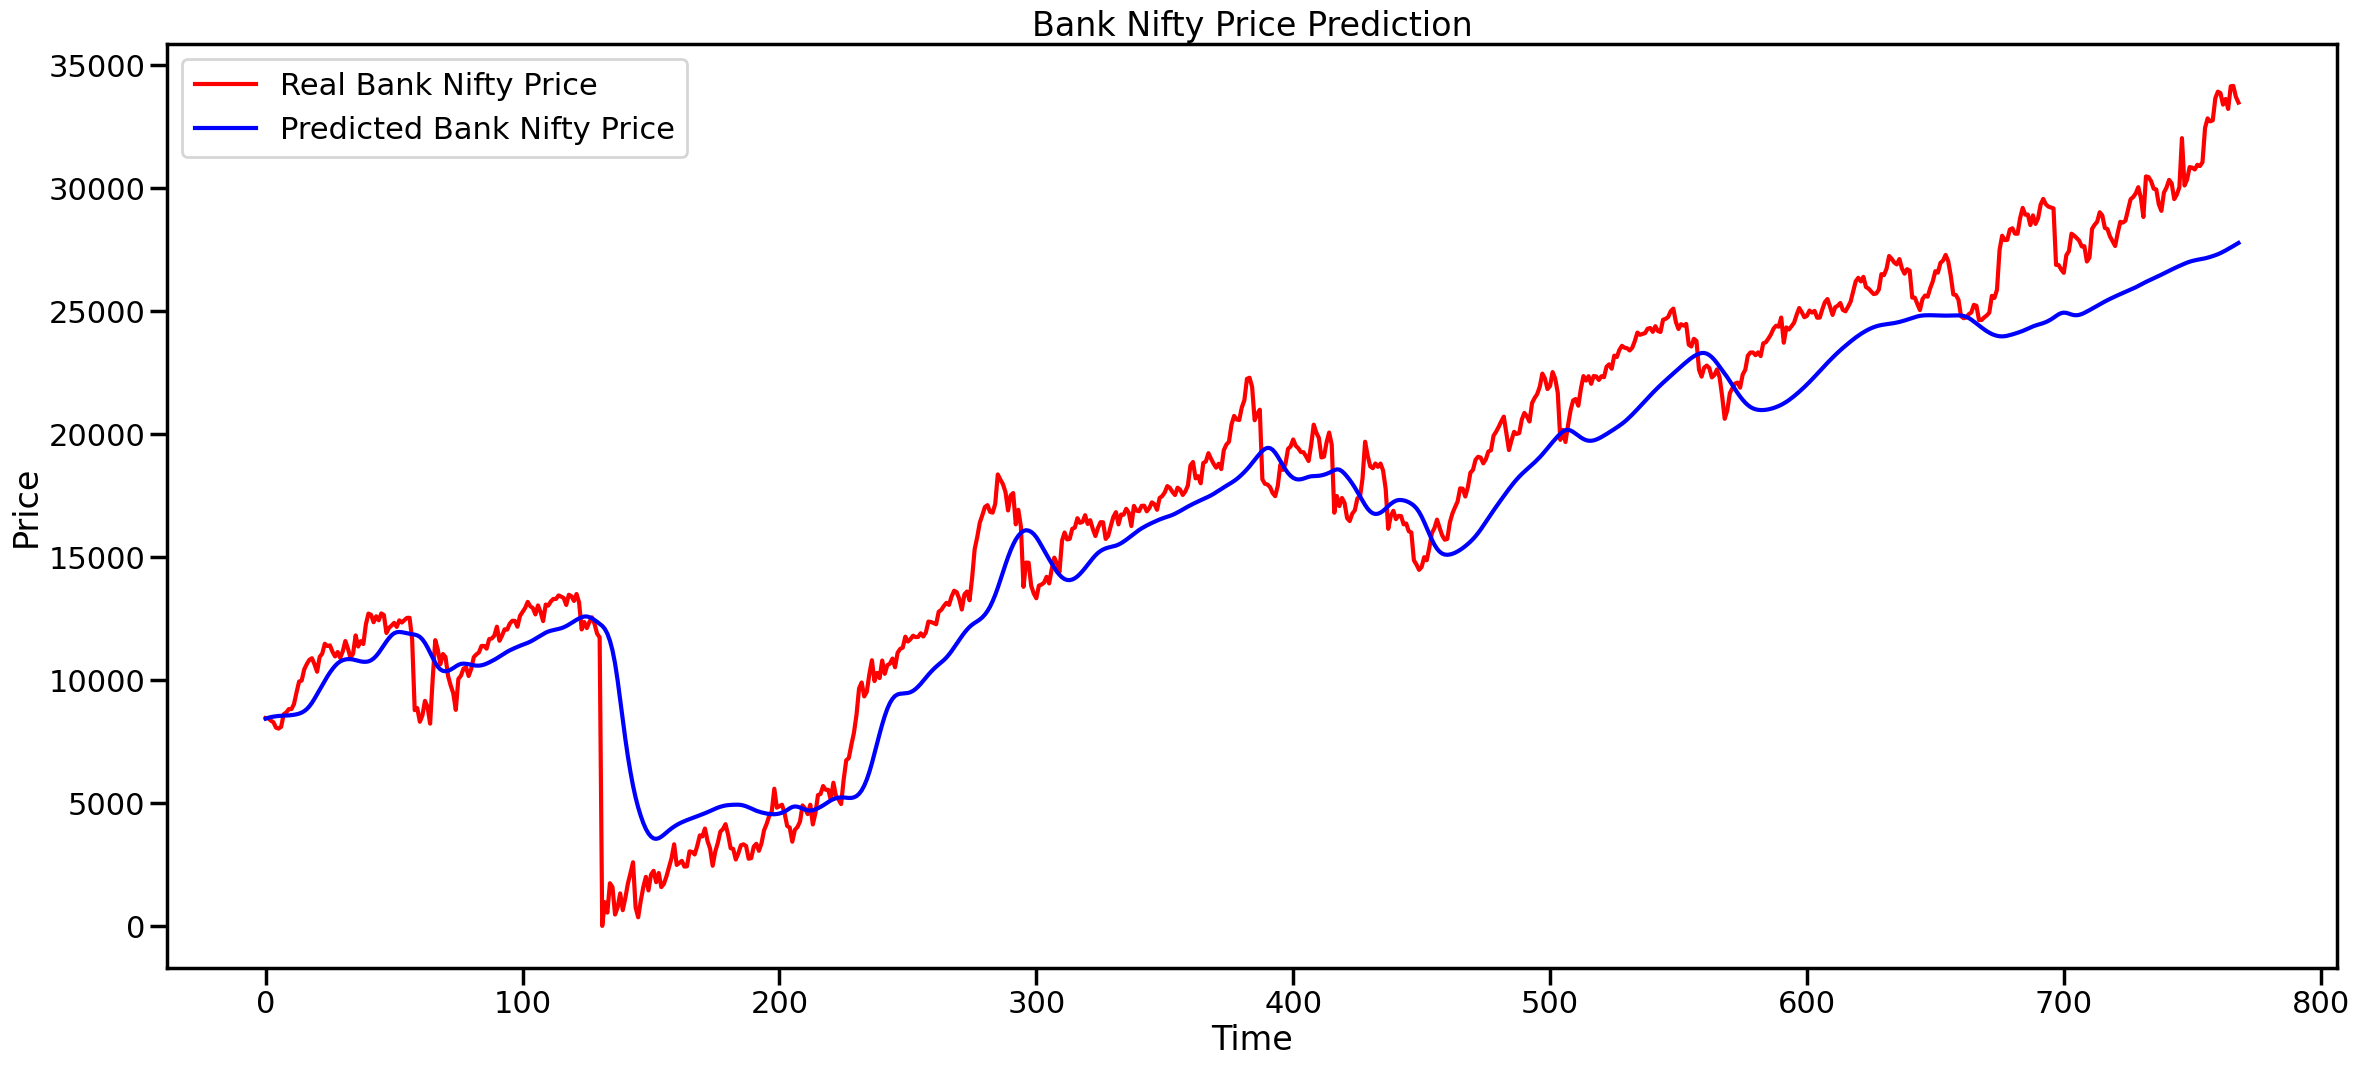

In [84]:
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Bank Nifty Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Bank Nifty Price')
plt.title('Bank Nifty Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()